In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sasmodels.core import load_model
from sasmodels.direct_model import DirectModel
from sasmodels.data import Data1D
from sasmodels.mixture import *
import glob, json, re

In [90]:
def load_data_from_file(fname):
    saxs = np.load(fname)
    dIq = 0.05 * saxs["Iq"]
    data = Data1D(x=saxs["q"], y=saxs["Iq"], dy=dIq) 

    return data

comps = pd.read_csv("../../misc/saxs_050825.csv")

In [91]:
sphere = load_model("sphere")
capped_cylinder = load_model("capped_cylinder")

model_info = make_mixture_info([sphere.info, capped_cylinder.info], operation="+")
model = MixtureModel(model_info, [sphere, capped_cylinder])


In [92]:
sphere_params = {"scale" : 1e-5,
                 "sld" : 124.823,
                 "sld_solvent" : 9.469,
                 "radius" : 10.0,
            }

capped_cylinder_params = {"scale" : 1e-5,
                 "sld" : 124.823,
                 "sld_solvent" : 9.469,
                 "radius" : 10.0,
                 "length" : 100.0,
                 "radius_cap" : 50.0
            }

Plotting ./merged_data/8.npz


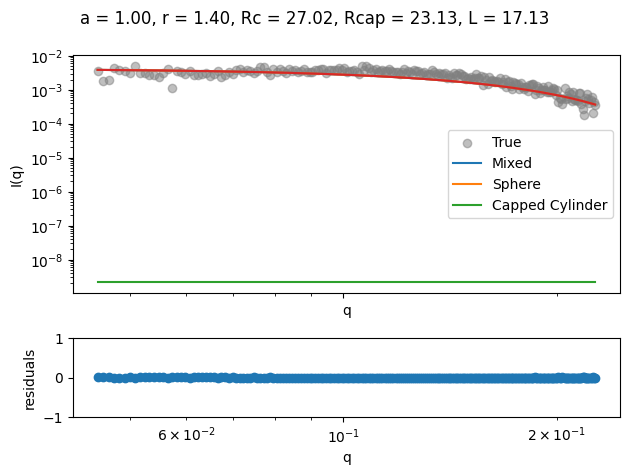

Plotting ./merged_data/9.npz


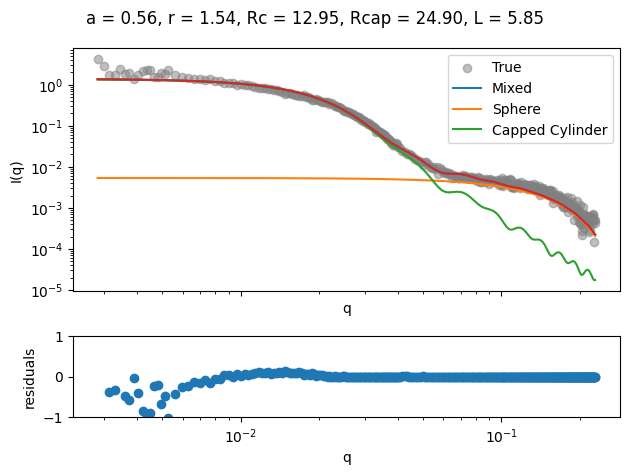

Plotting ./merged_data/14.npz


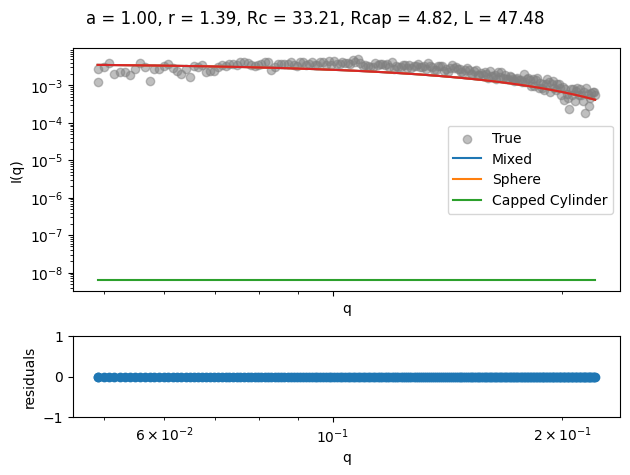

Plotting ./merged_data/15.npz


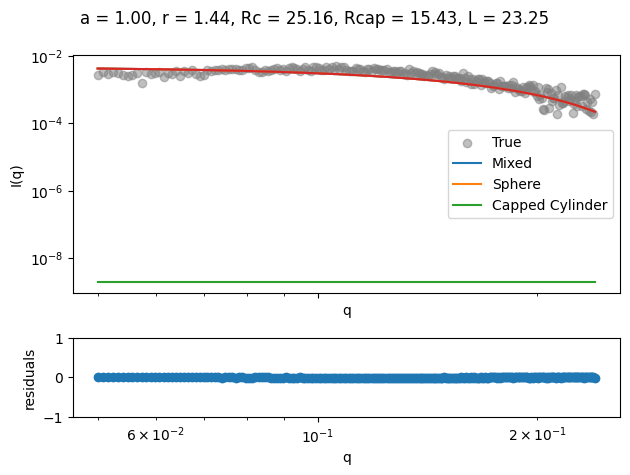

Plotting ./merged_data/17.npz


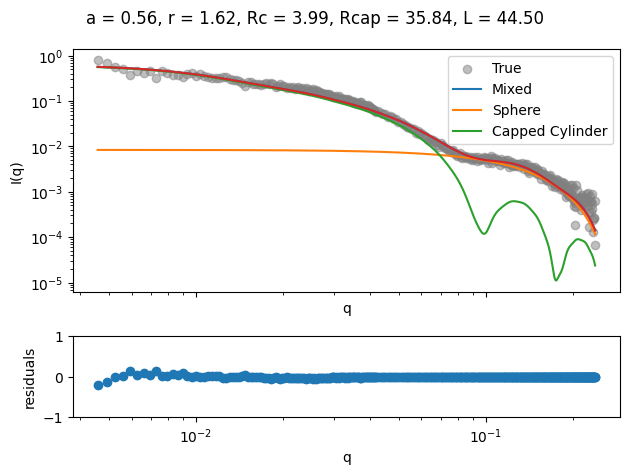

Plotting ./merged_data/16.npz


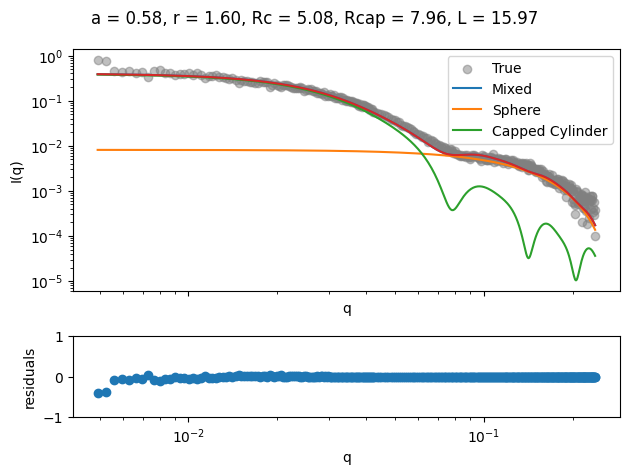

Plotting ./merged_data/12.npz


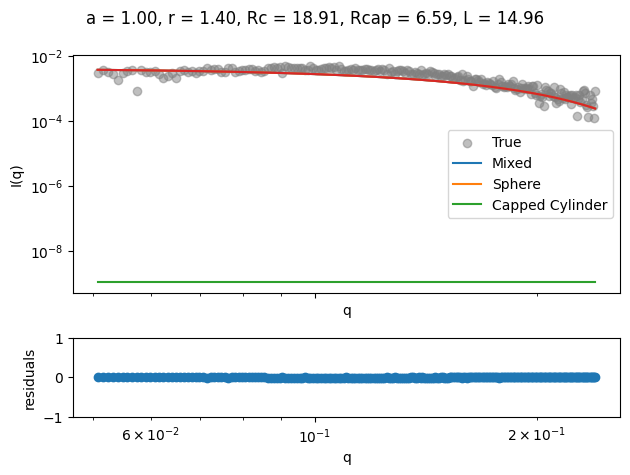

Plotting ./merged_data/13.npz


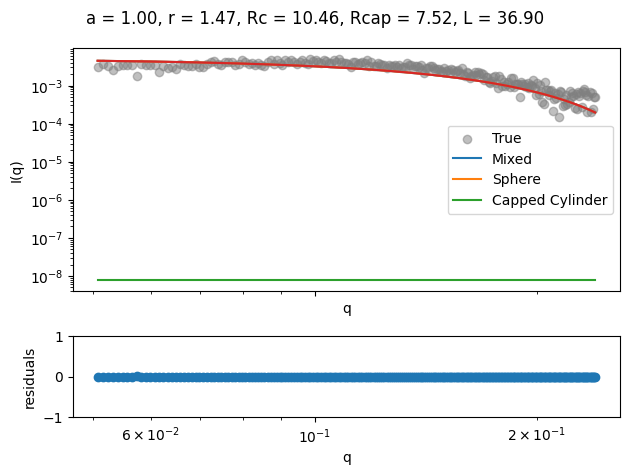

Plotting ./merged_data/11.npz


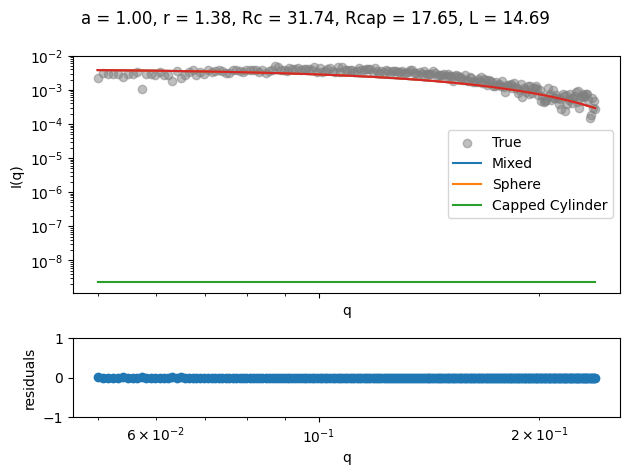

Plotting ./merged_data/10.npz


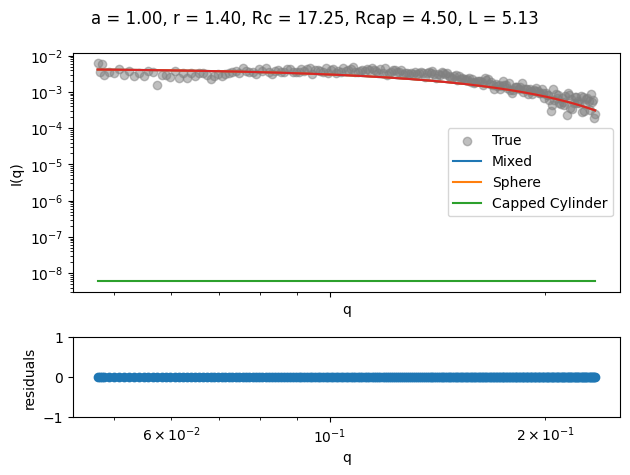

Plotting ./merged_data/18.npz


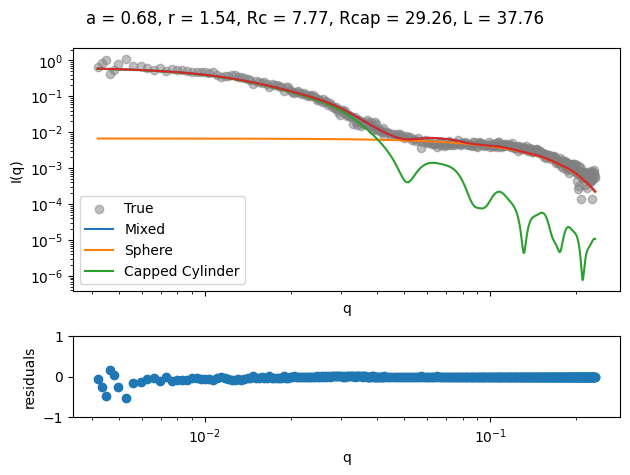

Plotting ./merged_data/19.npz


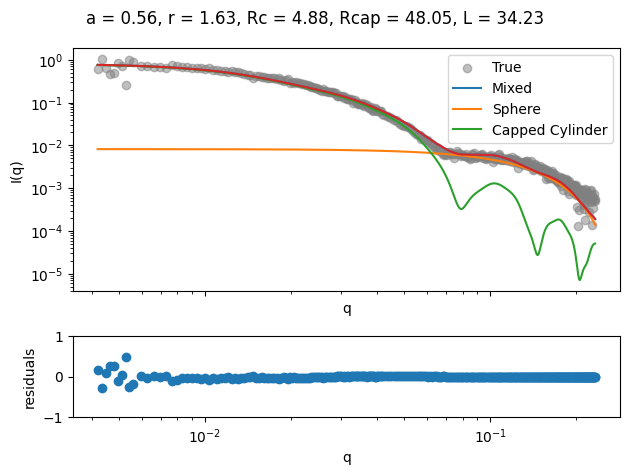

Plotting ./merged_data/4.npz


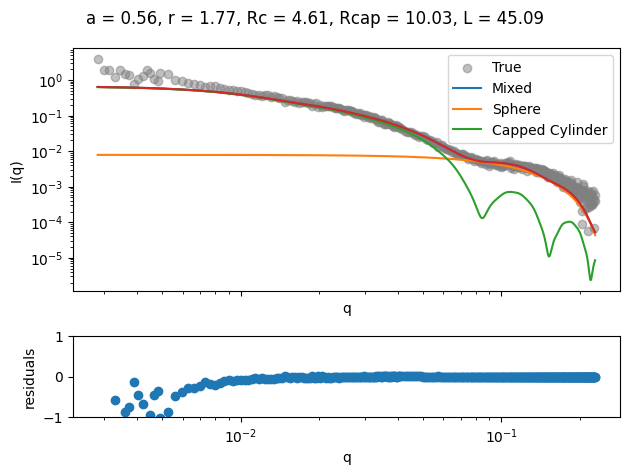

Plotting ./merged_data/5.npz


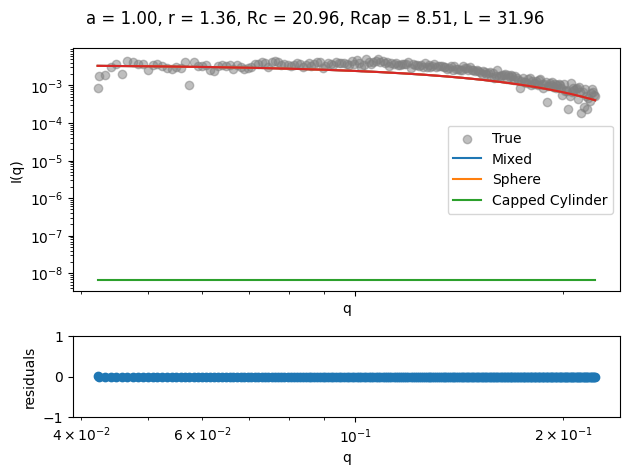

Plotting ./merged_data/7.npz


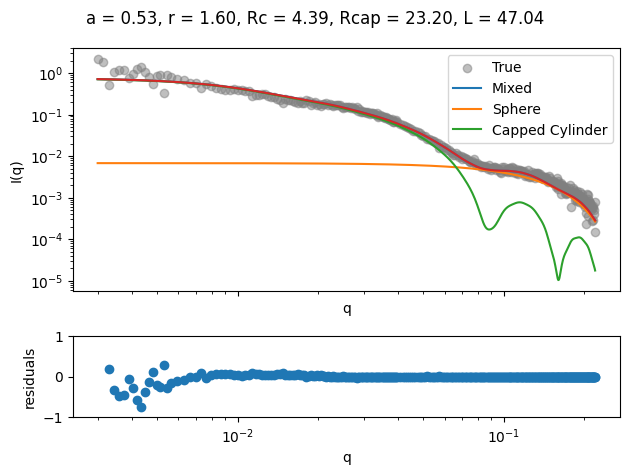

Plotting ./merged_data/6.npz


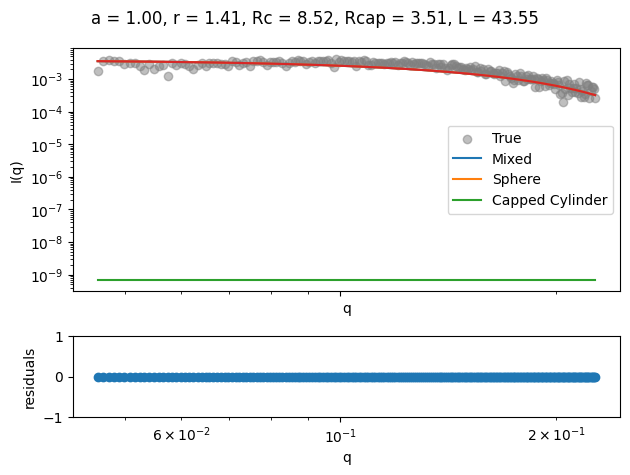

Plotting ./merged_data/2.npz


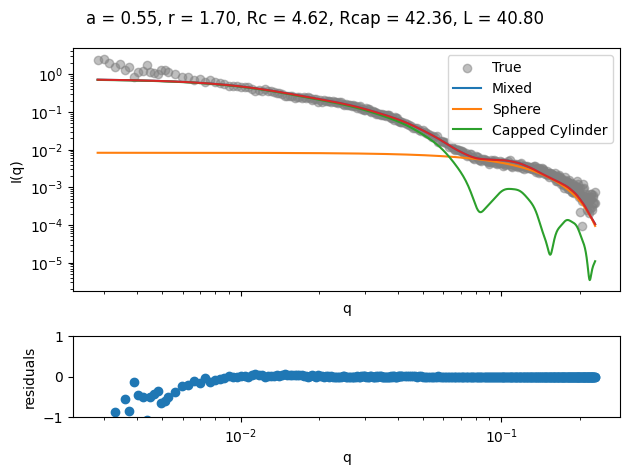

Plotting ./merged_data/3.npz


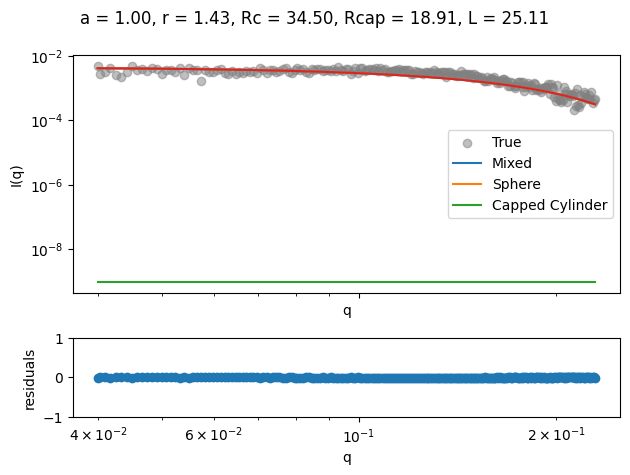

Plotting ./merged_data/1.npz


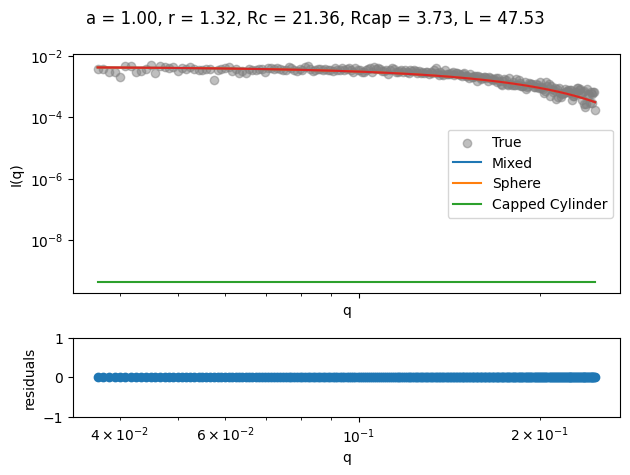

In [93]:
data_files = glob.glob("./merged_data/*.npz")
json_params = []
for fname in data_files:
    print("Plotting %s"%fname)
    data = load_data_from_file(fname)
    match = re.search(r'/(\d+)\.npz$', fname)
    ind = int(match.group(1))
    with open("./fits_v1/%d/best_params.json"%ind, 'r') as file:
        params = json.load(file)

    calculator = DirectModel(data, model)
    Iq_mix = calculator(**params)

    calculator_sphere = DirectModel(data, sphere)
    sphere_params.update({"scale" : params["A_scale"]})
    sphere_params.update({"radius" : params["A_radius"]})
    Iq_sphere = params["scale"]*calculator_sphere(**sphere_params)


    calculator_capped_cyl = DirectModel(data, capped_cylinder)
    capped_cylinder_params.update({"scale" : params["B_scale"]})
    capped_cylinder_params.update({"radius" : params["B_radius"]})
    capped_cylinder_params.update({"length" : params["B_length"]})
    capped_cylinder_params.update({"radius_cap" : params["B_radius_cap"]})
    Iq_capcyl = params["scale"]*calculator_capped_cyl(**capped_cylinder_params)

    alpha = (Iq_sphere/Iq_mix).mean()
    title = "a = %.2f, r = %.2f, Rc = %.2f, Rcap = %.2f, L = %.2f"%(alpha,
                                         params["A_radius"]*0.1,
                                         params["B_radius"]*0.1,
                                         params["B_radius_cap"]*0.1,
                                         params["B_length"]*0.1
                                    
                                    )

    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(title)

    axs[0].scatter(data.x, data.y, color="grey", alpha=0.5, label='True')
    axs[0].plot(data.x, Iq_mix, label="Mixed")
    axs[0].plot(data.x, Iq_sphere, label="Sphere")
    axs[0].plot(data.x, Iq_capcyl, label='Capped Cylinder')
    axs[0].plot(data.x, Iq_capcyl+Iq_sphere)

    axs[0].set_xlabel('q')
    axs[0].set_ylabel('I(q)')
    axs[0].legend()
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # plot residuals
    residuals = (Iq_mix - data.y)
    axs[1].scatter(data.x, residuals)
    axs[1].set_ylim([-1.0, 1.0])
    axs[1].set_xlabel('q')
    axs[1].set_ylabel('residuals')
    axs[1].set_xscale('log')
    plt.tight_layout()
    plt.show()

    # add the data to json file
    data = {"AA" : float(comps.iloc[ind]["AA"]),
            "SN" : float(comps.iloc[ind]["SN"]),
            "alpha" : alpha,
            "r_sphere" : params["A_radius"]*0.1,
            "r_cap_cyl_length" : params["B_length"]*0.1,
            "r_cap_cyl_radius" : params["B_radius"]*0.1,
            "r_cap_cyl_cap_radius": params["B_radius_cap"]*0.1,
            "units" : "nm"
    }
    json_params.append(data)

In [94]:
with open('./fitted_params.json', 'w') as outfile:
    json.dump(json_params, outfile)